# By: Sophia Tran, Hanbin Go, Troy Freiburger

The following contains a python implementation of the algebra described in [*Computing with Cognitive States* by Stefan Reimann](https://arxiv.org/abs/2111.06969).

In [1]:
from scipy.stats import binom # binomial distribution function - corresponds to hamming distance bewteen two randomly generated states
import numpy as np #huge library with numerical functions - we use this to generate random numbers and also the state space
import matplotlib.pyplot as plt #plotting library
%matplotlib inline

N = 200 #Length of state "Number of neurons" - dimension in each array 
kappa = 4 #Similarity weight, as defined in paper Eq. (2)
#note  that bundling creates an array; hamming distance is a number
#Activation probability when bundling one active and one inactive neuron - threshould probability or probability that it will be 0 or 1
#i.e. 1+0 = {0 with probability p, 1 with probability 1-p} 
# this is defined in Eq. (3) 
p = 0.5 

Think about how the distances are distributed between two randomly chosen states in the Hamming space. The probability that a random state is a Hamming distance $d$ from another is given by
$$\mathbb{P} [D = d] = \frac{\text{\# of bit strings of distance }d}{\text{total \# of bit strings}}= \frac{\begin{pmatrix}N \\ d\end{pmatrix}}{\sum_{j=0}^{N} \begin{pmatrix}N \\ j\end{pmatrix}} = 2^{-N} \begin{pmatrix}N \\ d\end{pmatrix}.$$
Here, $d$ is a fixed number, and $D$ is the random variable corresponding to the Hamming distance of a randomly generated bit string. It follows that the cumulative distribution function is given by
$$\mathbb{P} [D \leq d] =\mathbb{P} [D = 0]+\mathbb{P} [D = 1]+\mathbb{P} [D = 2]+...+\mathbb{P} [D = d] =\sum^d_{j=0} \mathbb{P} [D = j] = 2^{-N}\sum^d_{j=0} \begin{pmatrix}N \\ j\end{pmatrix}.$$
interpreted as the probability that a random bit string of length $N$ is within a Hamming distance $d$ of another. Formally, this means that the distance between two uniformly distributed states in a Hamming space $D$ is a Binomial random variable with equal weight probability $D \sim \text{Binom}(N,p=1/2)$, see [wiki article](https://en.wikipedia.org/wiki/Binomial_distribution).

In [2]:
#using numpy

def ham_dist(A,B): #this is an array to calculate the hamming distance
    #Calculate number of positions with different bits


    return np.sum(np.abs(A-B)) #array A - Array B; sum the absolute value

def similarity(d): #taken from paper Eq.(2), using scipy.stats.binom to retrieve binomial cummulative distribution function
    
    return np.exp(-1*kappa*binom.cdf(d,N,p))
        
def bundle(x,y):
    '''Bundle arrays element-wise'''
    #x and y can be either 0 or 1; if x equals y, stay the same, multiply by 0, this gives us the bundling truth table;
    #if x doesn't equal while, draw from probability p
    #starts with an array of all 0s, then activates those that were both previously active then activates different pairs based off of probability
    
    #If two neurons are active, they remain active
    z = (x==y)*x
    
    #If on active and one inactive, result will be inactive with probability p
    z = z + (x != y)*np.random.binomial(1,p,N)
    
    return z 

def bind(x,y):
    '''Bind arrays element-wise'''  #gives you a 1 wherever they are equal and 0 wherever they are not equal; multiply by 1 to change True and False to
    # 1s and 0s as per Eq. (3) - Binding 
    
    return (x == y)*1

def left_state(mem_list): #Eq.(6)
    '''Left bundle a memory list (recency)'''
    
    L = mem_list[0] #start bundling with initial state in list; L is the initial state
    for j in range(1,len(mem_list)): #for each addition cue in the list, you bundle them from left to right
        L = bundle(L,mem_list[j])
        
    return L #will give a state consisting of the left bundle of all cues

def right_state(mem_list): #Eq. (7)
    '''Right bundle a memory list (primacy)'''
    
    R = mem_list[-1] #start bundling with final state in list; -1 is last on list

    for j in range(2,len(mem_list)+1):

        R = bundle(R,mem_list[-j]) #bundling in reverse
    
    return R

## Distance profiles

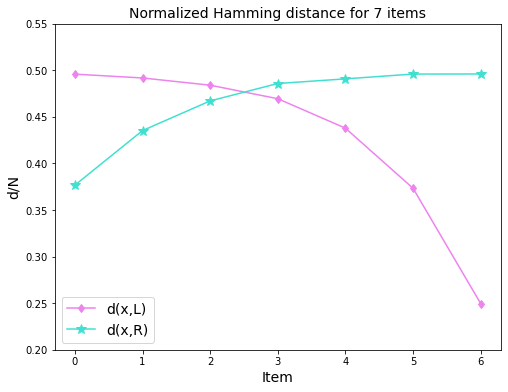

In [3]:
#now we combine everything
#representing bit strings as arrays

def LRdistance_profile(num_items): #based on Figure 3.

    q = 0.5 #Mean neuron activation probability
    mem_list = [np.zeros(N)] #Initialize with empty state/array as per page 6 of Computing Cognitive States Paper; array of all 0 intergers 
                                            #essenitally a bit string or array of 0

    for j in range(num_items): #generate all of the cues based on number that we specify ; essentially making 7 randomly generated cues 
                                #using mean threshold activation; each cue is an array 
        mem_list.append(np.random.binomial(1,q,N)) #append generates each cue and adds it to the list of cues; generates a state 
                                                    #with activation probability/q = 0.5
    #Now we bundle
    
    L, R = left_state(mem_list), right_state(mem_list) #l and r are the left and right bundle memory states which are calculated using 
                                                        #the functions we defined
    
    ldists, rdists = [], [] #starts as a empty list, but then we append the hamming distance relative to each cue
    lsims, rsims = [], [] #empty list for similarity
    for j in range(1,len(mem_list)):
        
        ldist = ham_dist(L,mem_list[j])
        rdist = ham_dist(R,mem_list[j])

        ldists.append(ldist) #skips initial state, and compares the rest iteratively; comparing original memory list to L bundled
        rdists.append(rdist) #same but compares to R bundled 
        
        lsims.append(similarity(ldist))
        rsims.append(similarity(rdist))
        
    return np.array(ldists)/N, np.array(rdists)/N, np.array(lsims), np.array(rsims) # this returns proportion of hamming distance relative state space size.

def sim(num_items): 
    dLs,dRs,aLs,aRs = [],[],[],[]
    for i in range(500): #run the simulation 500 times.
        dL,dR,aL,aR = LRdistance_profile(num_items)
        dLs.append(dL)
        dRs.append(dR)
        aLs.append(aL)
        aRs.append(aR)
    return(dLs,dRs,aLs,aRs)
        

num_items = 7 #7 items as per computing cognitive states paper
ldist, rdist,lsim,rsim = sim(num_items)

plt.figure(figsize = (8,6))
plt.plot(np.mean(ldist, axis=0), marker='d', 
         color = 'violet',markersize = 6,label = 'd(x,L)')
plt.plot(np.mean(rdist, axis=0), marker='*', 
         color = 'turquoise',markersize = 10,label = 'd(x,R)')

plt.ylim(0.2,0.55)
plt.xlabel('Item', fontsize = 14)
plt.ylabel('d/N',fontsize = 14)
plt.title('Normalized Hamming distance for {} items'.format(num_items),
          fontsize = 14)
plt.legend(loc=3,fontsize = 14)
plt.show()

#L has the smallest distances to the most recent items, while R has the closest to the early list items.

## Activity Gradients

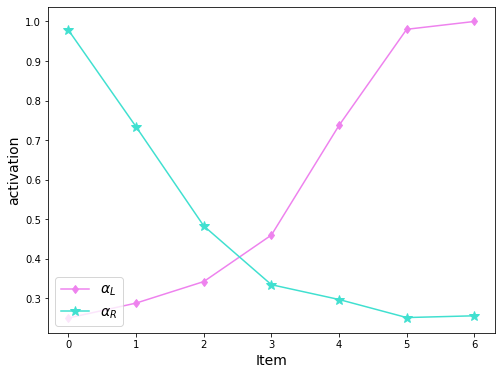

In [4]:
#Figure 4 from the paper : Primacy and Recency Gradients
plt.figure(figsize = (8,6))
plt.plot(np.mean(lsim, axis=0) , marker='d',
         color = 'violet',markersize = 6,label = r'$\alpha_{L}$')
plt.plot(np.mean(rsim, axis=0), marker='*', 
         color = 'turquoise',markersize = 10,label = r'$\alpha_{R}$')

plt.xlabel('Item', fontsize = 14)
plt.ylabel('activation',fontsize = 14)
plt.legend(loc=3,fontsize = 14)
plt.show()

#activation L = recency gradient, activation R = primacy gradient

## Recency Effects of Various List Lengths

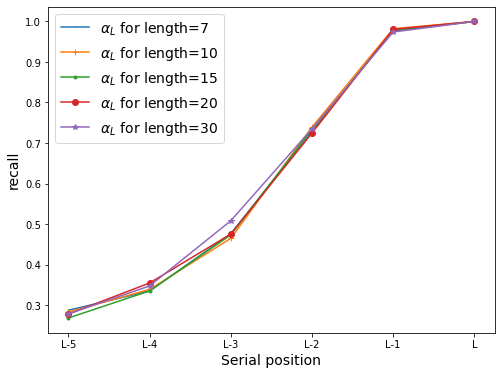

In [5]:
import itertools
plt.figure(figsize = (8,6))
num_lists = [7,10,15,20,30]
marker = itertools.cycle((',', '+', '.', 'o', '*')) 
for n in num_lists:
    _,_,lsim,_ = sim(n)
    plt.plot(np.mean(lsim, axis=0)[-6:],marker = next(marker),markersize = 6,label = r'$\alpha_L$ for length={}'.format(n))

labels = ['L-5','L-4','L-3','L-2','L-1','L']
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Serial position', fontsize = 14)
plt.ylabel('recall',fontsize = 14)
plt.legend(loc=2,fontsize = 14)
plt.show()

## Cued Recall

In [6]:
#Figure 7 cued recall: Given cues such as x, y ,z.
def binding(num_items, state = 'R'):

    q = 0.5 #Mean neuron activation probability
    mem_list1 = [np.zeros(N)] #item list[a,b,c,d..]  #zeros
    mem_list2 = [np.zeros(N)] # cues list [x,y,z,w,..] #zeros                             

    for j in range(num_items): #generate all of the cues based on number that we specify ; essentially making 7 randomly generated cues 
                                #using mean threshold activation; each cue is an array 
        mem_list1.append(np.random.binomial(1,q,N)) #append generates each cue and adds it to the list of cues; generates a state
        mem_list2.append(np.random.binomial(1,q,N))                                
    
    #Now we bind
    binded_list = bind(np.array(mem_list1),np.array(mem_list2))   
    sims, sims_X, sims_Y, sims_Z,  sims_W = [], [], [], [], [] #empty list for similarity
    for j in range(1,len(binded_list)):
        
        L, R = left_state(binded_list), right_state(binded_list)
        #compute similarity
        if state == 'R':
            sim = similarity(ham_dist(R, binded_list[j]))
            sim_X = similarity(ham_dist(bind(mem_list2[1],R),mem_list1[j]))
            sim_Y = similarity(ham_dist(bind(mem_list2[2],R),mem_list1[j]))
            sim_Z = similarity(ham_dist(bind(mem_list2[3],R),mem_list1[j]))
            sim_W = similarity(ham_dist(bind(mem_list2[4],R),mem_list1[j]))
            sims.append(sim)
            sims_X.append(sim_X)
            sims_Y.append(sim_Y)
            sims_Z.append(sim_Z)
            sims_W.append(sim_W)
        
        if state == 'L':
            sim = similarity(ham_dist(L, binded_list[j]))
            sim_X = similarity(ham_dist(bind(mem_list2[-1],L),mem_list1[j]))
            sim_Y = similarity(ham_dist(bind(mem_list2[-2],L),mem_list1[j]))
            sim_Z = similarity(ham_dist(bind(mem_list2[-3],L),mem_list1[j]))
            sim_W = similarity(ham_dist(bind(mem_list2[-4],L),mem_list1[j]))
            sims.append(sim)
            sims_X.append(sim_X)
            sims_Y.append(sim_Y)
            sims_Z.append(sim_Z)
            sims_W.append(sim_W)
        
    return sims, sims_X, sims_Y, sims_Z, sims_W


## Primacy Cued Recall

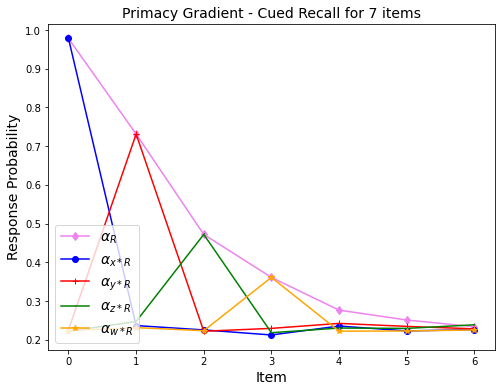

In [7]:
def simulate(num_items): 
    aR, axR, ayR, azR, awR = [],[],[],[],[]
    for i in range(500): #run the simulation 500 times.
        rsim,rsimX,rsimY,rsimZ,rsimW= binding(7)
        aR.append(rsim)
        axR.append(rsimX)
        ayR.append(rsimY)
        azR.append(rsimZ)
        awR.append(rsimW)
    return(aR,axR,ayR,azR,awR)

num_items = 7
rsim, rsim_x, rsim_y, rsim_z, rsim_w= simulate(7)

plt.figure(figsize = (8,6))
plt.plot(np.mean(rsim, axis=0) , marker='d',
         color = 'violet',markersize = 6,label = r'$\alpha_{R}$')
plt.plot(np.mean(rsim_x, axis=0) , marker='o',
         color = 'blue',markersize = 6,label = r'$\alpha_{x*R}$')
plt.plot(np.mean(rsim_y, axis=0) , marker='+',
         color = 'red',markersize = 6,label = r'$\alpha_{y*R}$')
plt.plot(np.mean(rsim_z, axis=0) , marker=',',
         color = 'green',markersize = 6,label = r'$\alpha_{z*R}$')
plt.plot(np.mean(rsim_w, axis=0) , marker='*',
         color = 'orange',markersize = 6,label = r'$\alpha_{w*R}$')
plt.xlabel('Item', fontsize = 14)
plt.ylabel('Response Probability',fontsize = 14)
plt.title('Primacy Gradient - Cued Recall for {} items'.format(num_items),
          fontsize = 14)
plt.legend(loc=3,fontsize = 14)
plt.show()

## Recency Cued Recall

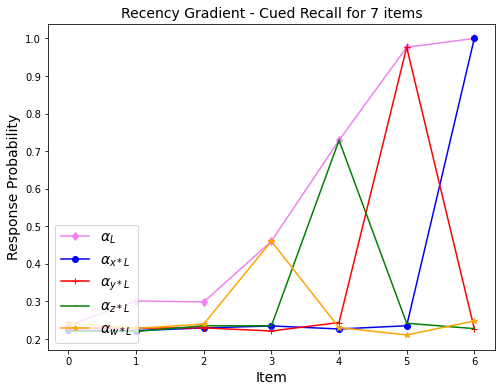

In [8]:
def simulate(num_items): 
    aR, axR, ayR, azR, awR = [],[],[],[],[]
    for i in range(500): #run the simulation 500 times.
        rsim,rsimX,rsimY,rsimZ,rsimW= binding(7, state = 'L')
        aR.append(rsim)
        axR.append(rsimX)
        ayR.append(rsimY)
        azR.append(rsimZ)
        awR.append(rsimW)
    return(aR,axR,ayR,azR,awR)

num_items = 7
rsim, rsim_x, rsim_y, rsim_z, rsim_w= simulate(7)

plt.figure(figsize = (8,6))
plt.plot(np.mean(rsim, axis=0) , marker='d',
         color = 'violet',markersize = 6,label = r'$\alpha_{L}$')
plt.plot(np.mean(rsim_x, axis=0) , marker='o',
         color = 'blue',markersize = 6,label = r'$\alpha_{x*L}$')
plt.plot(np.mean(rsim_y, axis=0) , marker='+',
         color = 'red',markersize = 6,label = r'$\alpha_{y*L}$')
plt.plot(np.mean(rsim_z, axis=0) , marker=',',
         color = 'green',markersize = 6,label = r'$\alpha_{z*L}$')
plt.plot(np.mean(rsim_w, axis=0) , marker='*',
         color = 'orange',markersize = 6,label = r'$\alpha_{w*L}$')
plt.xlabel('Item', fontsize = 14)
plt.ylabel('Response Probability',fontsize = 14)
plt.title('Recency Gradient - Cued Recall for {} items'.format(num_items),
          fontsize = 14)
plt.legend(loc=3,fontsize = 14)
plt.show()